# Creating Factor Graphs with Seed and Running Simulations

This notebook demonstrates how to create factor graphs on the spot with a specified seed and run simulations with them.


In [1]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from pathlib import Path

# Import necessary modules for factor graph creation and simulation
from bp_base.factor_graph import FactorGraph
from bp_base.agents import VariableAgent, FactorAgent
from bp_base.bp_engine_base import BPEngine
from bp_base.engines_realizations import (
    SplitEngine,
    DampingEngine,
    CostReductionOnceEngine,
    DampingCROnceEngine,
    DampingSCFGEngine
)
from utils.create_factor_graphs_from_config import (
    _make_variable,
    _make_factor,
    build_cycle_graph,
    build_random_graph
)
from configs.global_config_mapping import CT_FACTORIES
from utils.path_utils import find_project_root

# Set the project root
PROJECT_ROOT = find_project_root()


NetworkX version: 3.4.2
Attempting to load: C:\Users\Public\projects\Belief_propagation_simulator_\configs\factor_graphs\factor-graph-cycle-3-random_intlow1,high100-number5.pkl
File does not exist: C:\Users\Public\projects\Belief_propagation_simulator_\configs\factor_graphs\factor-graph-cycle-3-random_intlow1,high100-number5.pkl
Available factor graph files in C:\Users\Public\projects\Belief_propagation_simulator_\configs\factor_graphs:
  - factor-graph-random-30-random_intlow100,high2000.3-number0.pkl
Using first available file: C:\Users\Public\projects\Belief_propagation_simulator_\configs\factor_graphs\factor-graph-random-30-random_intlow100,high2000.3-number0.pkl
Graph loaded. Type: <class 'bp_base.factor_graph.FactorGraph'>

Factor graph details:
Variables: 30
Factors: 130
Graph nodes: 160
Graph edges: 260

First few nodes:
  - X1
  - X2
  - X3
  - X4
  - X5

First variable: x1, Domain: 10

First factor: f12
Cost table shape: (10, 10)

Repaired graph saved to: C:\Users\Public\proj

## Set a Random Seed for Reproducibility

Setting a seed ensures that the random factor graphs created will be the same each time the notebook is run.


In [2]:
# Set a seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

print(f"Using seed: {SEED}")


Using seed: 42


## Create Factor Graphs Directly

Instead of loading factor graphs from pickle files, we'll create them directly with our specified seed.


In [3]:
def create_factor_graph(graph_type="cycle", num_vars=5, domain_size=3, ct_factory="random_int", ct_params=None, density=0.5):
    """
    Create a factor graph directly without going through the config and pickle process.

    Args:
        graph_type (str): Type of graph to create ("cycle" or "random")
        num_vars (int): Number of variables in the graph
        domain_size (int): Size of the domain for each variable
        ct_factory (str): Name of the cost table factory to use
        ct_params (dict): Parameters for the cost table factory
        density (float): Density of the graph (for random graphs)

    Returns:
        FactorGraph: The created factor graph
    """
    if ct_params is None:
        ct_params = {"low": 1, "high": 100}

    # Get the cost table factory function
    ct_factory_fn = CT_FACTORIES[ct_factory]
    if graph_type == "cycle":
        variables,factors,edges= build_cycle_graph(
            num_vars= num_vars,
            domain_size=domain_size,
            ct_factory=ct_factory_fn,
            ct_params=ct_params,
            density=density

        )


    if graph_type == "random":
        variables, factors, edges = build_random_graph(
            num_vars=num_vars,
            domain_size=domain_size,
            ct_factory=ct_factory_fn,
            ct_params=ct_params,
            density=density
        )
    else:
        raise ValueError(f"Unknown graph type: {graph_type}")

    # Create the factor graph
    fg = FactorGraph(variable_li=variables, factor_li=factors, edges=edges)

    return fg
# Create a random factor graph with the specified seed
random_fg = []
for i in range(1):
    random_fg.append(create_factor_graph(
        graph_type="random",
        num_vars=50,
        domain_size=20,
        ct_factory="random_int",
        ct_params={"low":1000, "high":10000},
        density=0.25)
    )



## Run Simulations with Different Engines

Now we'll run simulations with the created factor graphs using different engines, including the DampingEngine to demonstrate that damping works correctly after each step.


In [4]:
from utils.fg_utils import get_bound
from policies.convergance import ConvergenceConfig


def run_simulations(factor_graph, max_iter=20):
    """
    Run simulations with different engines on the given factor graph.

    Args:
        factor_graph (List[FactorGraph]): The factor graph to run simulations on
        max_iter (int): Maximum number of iterations to run

    Returns:
        dict: Dictionary mapping engine names to their costs over iterations
    """
    # Create engines
    engines = [BPEngine,DampingSCFGEngine,DampingEngine]


    # Run simulations
    results = {str(engine.__name__): [] for engine in engines}
    for graph in factor_graph:
        lb = get_bound(graph)
        print(lb)
        for engine in engines:
            import pickle
            import cProfile
            import pstats
            engine = engine(factor_graph=pickle.loads(pickle.dumps(graph)),normalize=True,convergence_config=ConvergenceConfig(),monitor_performance=True)
            print(f"Running simulation with {engine.__class__.__name__}...")
            profiler = cProfile.Profile()
            profiler.enable()
            engine.run(max_iter=max_iter, save_json=False, save_csv=False)
            profiler.disable()
            stats = pstats.Stats(profiler)
            stats.sort_stats('cumulative')
            stats.print_stats(20)

            results[str(engine.__class__.__name__)].append(engine.history.costs)

            print(f"Completed simulation with {engine.name}. Final cost: {engine.history.costs[-1]}")


    return [lb]*(max_iter*6),results



# Run simulations on the random factor graph
print("\nRunning simulations on random factor graph...")
lb1,random_results = run_simulations(random_fg)



Running simulations on random factor graph...
310205.0
Running simulation with BPEngine...
         21256372 function calls (21199726 primitive calls) in 38.790 seconds

   Ordered by: cumulative time
   List reduced from 328 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      2/1    0.000    0.000   38.790   38.790 C:\Users\Public\projects\Belief_propagation_simulator_\bp_base\bp_engine_base.py:158(run)
       20    0.004    0.000   38.754    1.938 C:\Users\Public\projects\Belief_propagation_simulator_\bp_base\bp_engine_base.py:137(cycle)
      160    0.251    0.002   37.443    0.234 C:\Users\Public\projects\Belief_propagation_simulator_\bp_base\bp_engine_base.py:74(step)
      160    0.008    0.000   15.823    0.099 C:\Users\Public\projects\Belief_propagation_simulator_\utils\performance.py:61(end_step)
      160    0.006    0.000   15.805    0.099 C:\Users\Public\projects\Belief_propagation_simulator_\.venv\Lib\site-packages\

## Plot the Results

Let's plot the costs over iterations for each engine to visualize the convergence behavior.


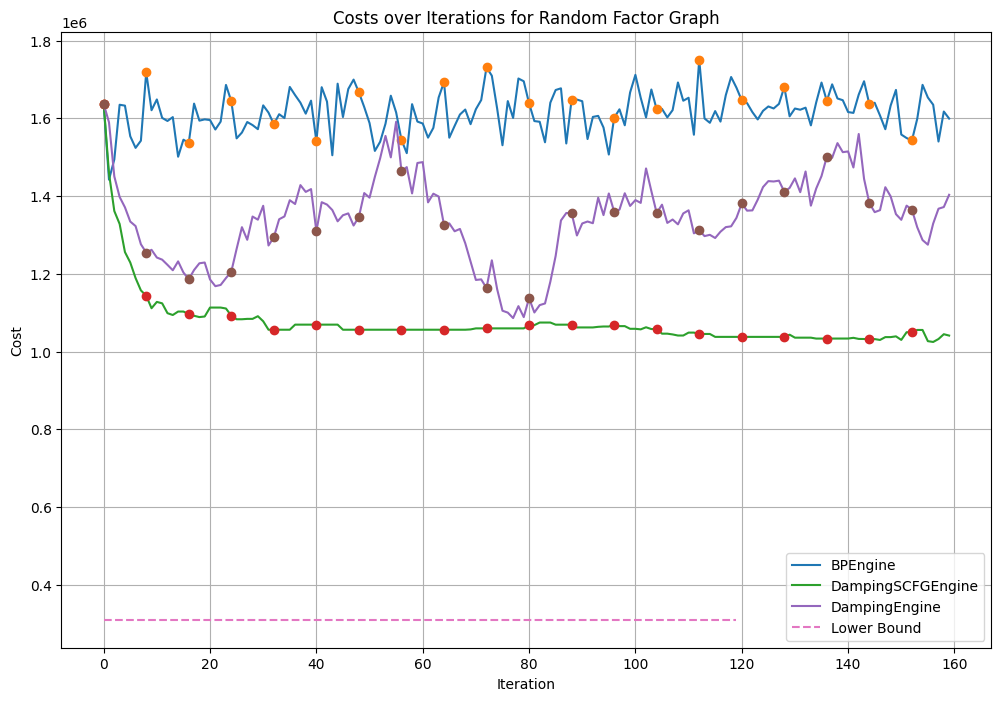

In [5]:
def plot_results(results, title):
    """
    Plot the costs over iterations for each engine.

    Args:
        results (dict): Dictionary mapping engine names to their costs over iterations
        title (str): Title for the plot
    """
    plt.figure(figsize=(12, 8))

    for engine_name, costs in results.items():
        max_len = max(len(c) for c in costs)
        costs = [c + [c[-1]] * (max_len - len(c)) for c in costs]
        plt.plot(np.average(np.array(costs), axis=0), label=engine_name)
        plt.plot(np.arange(0, max_len, 8), np.array([costs[0][int(i/8)*8] for i in range(0, max_len,8)]),linestyle='',marker='o')
    plt.plot(lb1,label ="Lower Bound",linestyle='--')
    plt.title(title)
    plt.xlabel('Iteration')
    plt.ylabel('Cost')
    plt.legend()
    plt.grid(True)
    plt.show()



# Plot results for random factor graph
plot_results(random_results, "Costs over Iterations for Random Factor Graph")


## Conclusion

This notebook demonstrates how to create factor graphs on the spot with a specified seed and run simulations with them. We've also verified that the damping functionality works correctly after each step.

Key points:
1. Setting a random seed ensures reproducibility of the factor graphs and simulation results.
2. The fixed damping implementation correctly applies damping after each variable computation step.
3. Different engines show different convergence behaviors on the same factor graph.